In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from os import path
from glob import glob
from tqdm import tqdm

from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA

from tensorflow import keras 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import InputLayer, Dense, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# create directory paths for images (from dataset)
base_dir = '../../overview/project_data/COMPLETE_DATASET'
train_dir = path.join(base_dir, 'TRAIN')
test_dir = path.join(base_dir, 'TEST')

print(train_dir)
print(test_dir)

../../overview/project_data/COMPLETE_DATASET/TRAIN
../../overview/project_data/COMPLETE_DATASET/TEST


In [3]:
# .jpg files of organic images from train data
train_org = glob(path.join(train_dir, 'O', '*.jpg'))
print('Number of organic (train) images: ', len(train_org))

Number of organic (train) images:  12565


In [4]:
# .jpg files of recyclable images from train data
train_re = glob(path.join(train_dir, 'R', '*.jpg'))
print('Number of recyclable (train) images: ', len(train_re))

Number of recyclable (train) images:  9999


In [5]:
# .jpg files of organic images from train data
test_org = glob(path.join(test_dir, 'O', '*.jpg'))
print('Number of organic (test) images: ', len(test_org))

Number of organic (test) images:  1401


In [6]:
# .jpg files of organic images from train data
test_re = glob(path.join(test_dir, 'R', '*.jpg'))
print('Number of recyclable (test) images: ', len(test_re))

Number of recyclable (test) images:  1112


In [7]:
print('Number of total (train + test) images: ', len(train_org)+len(train_re)+len(test_org)+len(test_re))
print('Number of train (organic + recyclable) images: ', len(train_org)+len(train_re))
print('Number of test (organic + recyclable) images: ', len(test_org)+len(test_re))

Number of total (train + test) images:  25077
Number of train (organic + recyclable) images:  22564
Number of test (organic + recyclable) images:  2513


In [8]:
x_data = []
y_data = []

for folder in glob(path.join(train_dir, '*')):
    for file in tqdm(glob(path.join(folder, '*.jpg'))):
        img_array = plt.imread(file)
        x_data.append(img_array)
        y_data.append(folder.split('/')[-1])

train_data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████████████████████████████████████████████████████████████| 12565/12565 [00:20<00:00, 614.46it/s]


In [9]:
train_data.shape

(22564, 2)

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22564 entries, 0 to 22563
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   22564 non-null  object
 1   label   22564 non-null  object
dtypes: object(2)
memory usage: 352.7+ KB


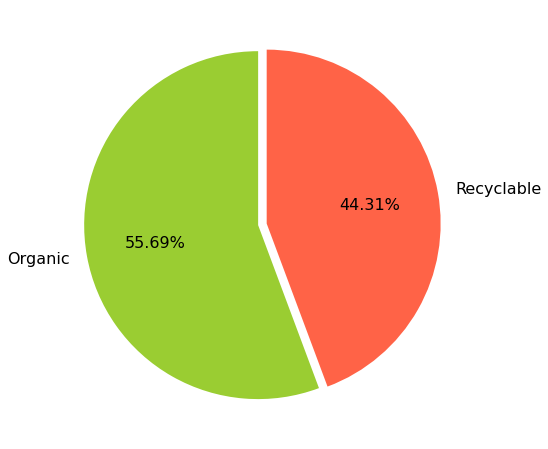

In [14]:
# pie chart of classes

plt.figure(figsize=(8,8))
plt.pie(train_data.label.value_counts(), 
        explode=[0.025,0.025],
        colors=['yellowgreen', 'tomato'],
        labels=['Organic', 'Recyclable'],
        autopct='%.2f%%',
        startangle=90,
        textprops={'fontsize':16})
plt.savefig('../04_data_visualizations/class_balance.png')
plt.show()

In [ ]:
# read and display organic image
plt.imshow(plt.imread(train_org[8]))

In [ ]:
# read and display recyclable images
plt.imshow(plt.imread(train_re[1]))

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(3,3,(i%12)+1)
    index=np.random.randint(22000)
    
    plt.imshow(train_data.image[index])
    plt.axis('off')
    
    if train_data.label[index] == 'O':
        plt.title('Organic Waste', fontdict={'size':24})
    else:
        plt.title('Recycable Waste', fontdict={'size':24})

plt.savefig('../04_data_visualizations/images_from_dataset.png')     
plt.show()

In [ ]:
# return shape for first 10 organic images
for img in train_org[0:10]:
    print((plt.imread(img)).shape)

In [ ]:
# return shape for first 10 recyclable images
for img in train_re[0:10]:
    print((plt.imread(img)).shape)

In [ ]:
# image scaling
data_generator = ImageDataGenerator(rescale = 1.0 / 255.0)

In [ ]:
# initialize train, validation, testing generator
train_generator = data_generator.flow_from_directory(
    train_dir,
    class_mode='binary',
    batch_size=32,
    seed=42)

test_generator = data_generator.flow_from_directory(
    test_dir, 
    class_mode='binary',
    batch_size=32,
    seed=42)

In [ ]:
train_generator.class_indices

In [ ]:
# iterate batches -> store the data in x_train, y_train
train_generator.reset()
x_train, y_train = next(train_generator)

#1st batch is already fetched before the for loop
for i in tqdm(range(int(len(train_generator)/32)-1)): 
    img, label = next(train_generator)
    x_train = np.append(x_train, img, axis=0 )
    y_train = np.append(y_train, label, axis=0)
print(x_train.shape, y_train.shape)

In [ ]:
# iterate batches -> store the data in x_test, y_test
test_generator.reset()
x_test, y_test = next(test_generator)

#1st batch is already fetched before the for loop.
for i in tqdm(range(int(len(test_generator)/32)-1)): 
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

print(x_test.shape, y_test.shape)

## NON DEEP LEARNING MODEL (RANDOM FOREST)

In [ ]:
print(x_train.ndim)
print(x_test.ndim)

In [ ]:
# reshape x_train values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_train.shape
x_train_2d = x_train.reshape((nsamples,nx*ny*nrgb))

In [ ]:
# reshape x_test values; sklearn expects 2D array
nsamples, nx, ny, nrgb = x_test.shape
x_test_2d = x_test.reshape((nsamples,nx*ny*nrgb))

In [ ]:
# reduce train data dimensions using PCA
pca = PCA(n_components=2)
pca.fit(x_train_2d)
x_train_2pc = pca.transform(x_train_2d)

# reduce test data dimensions using PCA
pca.fit(x_test_2d)
x_test_2pc = pca.transform(x_test_2d)

print(np.shape(x_train_2pc))
print(np.shape(x_test_2pc))

In [ ]:
# plot PCA 
plt.figure(figsize=(10,10))

sns.scatterplot(x=x_train_2pc[:, 0], y=x_train_2pc[:, 1],
                hue=y_train,
                palette=sns.color_palette("colorblind", 2))
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.savefig('../04_data_visualizations/pca_plot.png')
plt.show()

In [ ]:
# instantiate and fit non deep learning model
rf = ensemble.RandomForestRegressor(n_estimators=100)

rf.fit(x_train_2pc,y_train)

In [ ]:
# evaluate random forest
rf_y_pred = rf.predict(x_test_2pc)
rf_y_pred

In [ ]:
print(rf_y_pred.shape)
print(type(rf_y_pred))

In [ ]:
# evaluate using log loss
# where y_pred are probabilities and y_true are binary class labels
print(f"Random Forest Log Loss: {metrics.log_loss(y_test, rf_y_pred, eps=1e-15):,.4f}")

In [ ]:
# convert y_pred probabilities into binary labels
rf_y_pred = np.array([1.0 if num >= 0.5 else 0 for num in rf_y_pred])
rf_y_pred

In [ ]:
print(rf_y_pred.shape)
print(type(rf_y_pred))

In [ ]:
# evaluate
print(f"Random Forest MAE: {metrics.mean_absolute_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest MSE: {metrics.mean_squared_error(y_test, rf_y_pred):,.4f}")
print(f"Random Forest Accuracy: {metrics.accuracy_score(y_test, rf_y_pred):,.4f}")

### SIMPLE NEURAL NET

In [ ]:
snn = Sequential()

snn.add(Flatten(input_shape=x_train.shape[1:]))
snn.add(Dense(units=80, activation='relu'))
snn.add(Dense(units=40, activation='relu'))
snn.add(Dense(units=20, activation='relu'))
snn.add(Dense(units=10, activation='relu'))
snn.add(Dense(units=1, activation='sigmoid'))

snn.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
snn.summary()

In [ ]:
snn.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1)

In [ ]:
# evaluate simple neural net model
snn.evaluate(x_test,y_test)

In [ ]:
# evaluate simple neural net model
snn_y_pred = snn.predict(x_test)

In [ ]:
print(snn_y_pred.shape)
print(type(snn_y_pred))

In [ ]:
# evaluate using log loss
# where y_pred are probabilities and y_true are binary class labels
print(f"Random Forest Log Loss: {metrics.log_loss(y_test, snn_y_pred, eps=1e-15):,.4f}")

In [ ]:
# convert y_pred probabilities into binary labels
snn_y_pred = np.array([1.0 if num >= 0.5 else 0 for num in snn_y_pred])
snn_y_pred

In [ ]:
print(snn_y_pred.shape)
print(type(snn_y_pred))

In [ ]:
# evaluate using MAE, MSE, Accuracy
print(f"Simple Neural Net MAE: {metrics.mean_absolute_error(y_test, snn_y_pred):,.4f}")
print(f"Simple Neural Net MSE: {metrics.mean_squared_error(y_test, snn_y_pred):,.4f}")
print(f"Simple Neural Net Accuracy: {metrics.accuracy_score(y_test, snn_y_pred):,.4f}")